In [1]:
# Cell 1: Setup and All Necessary Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import os
import sys
import time

# Scikit-learn for DBSCAN and NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# HDBSCAN (make sure you've run 'pip install hdbscan')
import hdbscan

# Imports for the new ImprovedWireClustering class
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform # pdist for distances
from sklearn.metrics import silhouette_score # For hybrid evaluation
from scipy.optimize import minimize # Though not directly used in clustering, keep if part of larger class
# Cell 1: Setup and All Necessary Imports (ensure these are present)
# ... (existing imports) ...
from sklearn.neighbors import NearestNeighbors # Already there for DBSCAN, but explicitly mentioning for local density
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.decomposition import PCA # For linearity, direction
from scipy.spatial.distance import pdist # For pairwise distances (used in some feature engineering)
# import open3d as o3d # If you want to use Open3D's direct methods, but we've used sklearn alternatives.
print("All libraries imported. Ready to define our functions and load data.")

All libraries imported. Ready to define our functions and load data.


In [2]:
# Cell 2: Define Data Loading Function

def load_lidar_data_direct(file_path: str) -> pd.DataFrame:
    """
    Loads LiDAR point cloud data from a .parquet file directly within the notebook.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' was not found.")

    try:
        df = pd.read_parquet(file_path)
    except Exception as e:
        raise IOError(f"Error loading parquet file '{file_path}': {e}")

    required_columns = ['x', 'y', 'z']
    if not all(col in df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"DataFrame from '{file_path}' is missing required columns: {missing_cols}. Expected 'x', 'y', 'z'.")

    return df[required_columns]

print("`load_lidar_data_direct` function defined.")

`load_lidar_data_direct` function defined.


In [3]:
# Cell 3: Define Clustering Functions (DBSCAN, HDBSCAN, and EPS Estimation)

def perform_dbscan_clustering(points_df: pd.DataFrame, eps: float, min_samples: int) -> pd.DataFrame:
    """
    Performs DBSCAN clustering on 3D LiDAR points (x, y, z).
    """
    required_columns = ['x', 'y', 'z']
    if not all(col in points_df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in points_df.columns]
        raise ValueError(f"Input DataFrame is missing required columns: {missing_cols}. Expected 'x', 'y', 'z'.")

    points = points_df[required_columns].values

    print(f"  Starting DBSCAN clustering with eps={eps:.4f}, min_samples={min_samples}...")
    start_time = time.time()
    db = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = db.fit_predict(points)
    end_time = time.time()
    print(f"  DBSCAN finished in {end_time - start_time:.2f} seconds.")

    result_df = points_df.copy()
    result_df['cluster_id'] = clusters
    n_clusters = result_df['cluster_id'].nunique() - (1 if -1 in result_df['cluster_id'].unique() else 0)
    print(f"  DBSCAN found {n_clusters} clusters.")
    if -1 in result_df['cluster_id'].unique():
        noise_points = (result_df['cluster_id'] == -1).sum()
        print(f"  {noise_points:,} points identified as noise (cluster_id = -1).")
    if n_clusters > 10:
        print(f"  Cluster ID counts (top 10 clusters + noise):\n{result_df['cluster_id'].value_counts().sort_values(ascending=False).head(11).to_string()}")
    else:
        print(f"  Cluster ID counts:\n{result_df['cluster_id'].value_counts().sort_index().to_string()}")

    return result_df

def perform_hdbscan_clustering(points_df: pd.DataFrame, min_cluster_size: int, min_samples: int = None) -> pd.DataFrame:
    """
    Performs HDBSCAN clustering on 3D LiDAR points (x, y, z).
    """
    required_columns = ['x', 'y', 'z']
    if not all(col in points_df.columns for col in required_columns):
        missing_cols = [col for col in required_columns if col not in points_df.columns]
        raise ValueError(f"Input DataFrame is missing required columns: {missing_cols}. Expected 'x', 'y', 'z'.")

    points = points_df[required_columns].values

    print(f"  Starting HDBSCAN clustering with min_cluster_size={min_cluster_size}, min_samples={min_samples if min_samples is not None else min_cluster_size}...")
    start_time = time.time()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusters = clusterer.fit_predict(points)
    end_time = time.time()
    print(f"  HDBSCAN finished in {end_time - start_time:.2f} seconds.")

    result_df = points_df.copy()
    result_df['cluster_id'] = clusters
    n_clusters = result_df['cluster_id'].nunique() - (1 if -1 in result_df['cluster_id'].unique() else 0)
    print(f"  HDBSCAN found {n_clusters} clusters.")
    if -1 in result_df['cluster_id'].unique():
        noise_points = (result_df['cluster_id'] == -1).sum()
        print(f"  {noise_points:,} points identified as noise (cluster_id = -1).")
    if n_clusters > 10:
        print(f"  Cluster ID counts (top 10 clusters + noise):\n{result_df['cluster_id'].value_counts().sort_values(ascending=False).head(11).to_string()}")
    else:
        print(f"  Cluster ID counts:\n{result_df['cluster_id'].value_counts().sort_index().to_string()}")

    return result_df

def estimate_dbscan_eps(points_df: pd.DataFrame, n_neighbors: int = 5) -> float:
    """
    Estimates a suitable 'eps' value for DBSCAN using the K-distance graph method.
    """
    required_columns = ['x', 'y', 'z']
    if not all(col in points_df.columns for col in required_columns):
        raise ValueError(f"Input DataFrame is missing required columns: {points_df.columns.tolist()}. Expected 'x', 'y', 'z'.")

    points = points_df[required_columns].values
    print(f"  Estimating DBSCAN 'eps' using K-distance graph (k={n_neighbors})...")

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(points)
    distances, indices = nbrs.kneighbors(points)

    k_distances = np.sort(distances[:, n_neighbors-1], axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(k_distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {n_neighbors}-th nearest neighbor (k-distance)")
    plt.title(f"K-Distance Graph for DBSCAN 'eps' Estimation (k={n_neighbors})")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(f"  Please inspect the K-distance graph above. Look for a 'knee' or 'elbow' point.")
    print(f"  The Y-value at this elbow is a good candidate for 'eps'.")
    suggested_eps = np.percentile(k_distances, 90)
    print(f"  A heuristic-based suggestion for 'eps' (e.g., 90th percentile): {suggested_eps:.4f}")
    return suggested_eps

# Define SOR and RANSAC Plane functions as well in this cell or a new one after this
def perform_sor_outlier_removal(df: pd.DataFrame, nb_neighbors: int = 20, std_ratio: float = 2.0) -> pd.DataFrame:
    """
    Performs Statistical Outlier Removal (SOR) on a 3D point cloud using scikit-learn.
    """
    if df.empty:
        print("  Input DataFrame is empty, skipping SOR.")
        return df.copy()

    points_np = df[['x', 'y', 'z']].values.astype(np.float64)

    print(f"  Applying SOR (scikit-learn): nb_neighbors={nb_neighbors}, std_ratio={std_ratio}...")
    start_time = time.time()

    nbrs = NearestNeighbors(n_neighbors=nb_neighbors + 1, algorithm='auto').fit(points_np)
    distances, _ = nbrs.kneighbors(points_np)
    mean_distances_to_neighbors = np.mean(distances[:, 1:], axis=1)

    global_mean_dist = np.mean(mean_distances_to_neighbors)
    global_std_dist = np.std(mean_distances_to_neighbors)
    threshold = global_mean_dist + std_ratio * global_std_dist
    inlier_mask = mean_distances_to_neighbors < threshold
    inlier_indices = np.where(inlier_mask)[0]

    end_time = time.time()
    print(f"  SOR finished in {end_time - start_time:.2f} seconds.")

    df_filtered = df.iloc[inlier_indices].copy()
    print(f"  Original points: {len(df):,}, Inlier points: {len(df_filtered):,} (Removed: {len(df) - len(df_filtered):,})")

    return df_filtered

def perform_ransac_plane_segmentation(points_df: pd.DataFrame,
                                     distance_threshold: float = 0.1,
                                     max_iterations: int = 1000,
                                     min_points_in_plane: int = 50,
                                     num_planes_to_find: int = 1,
                                     random_state: int = None) -> pd.DataFrame:
    """
    Finds dominant planes in a 3D point cloud using RANSACRegressor (for Z=f(X,Y) planes).
    """
    required_columns = ['x', 'y', 'z']
    if not all(col in points_df.columns for col in required_columns):
        print("  Input DataFrame is missing x,y,z columns. Skipping RANSAC plane finding.")
        return points_df.copy()

    df_result = points_df.copy()
    df_result['cluster_id'] = -1

    points = points_df[required_columns].values
    
    current_unassigned_indices = np.arange(len(points))
    global_plane_id = 0

    print(f"\n  Starting RANSAC plane finding (max_planes={num_planes_to_find})...")

    for i_plane in range(num_planes_to_find):
        if len(current_unassigned_indices) < min_points_in_plane:
            print(f"    Remaining points ({len(current_unassigned_indices)}) below min_points_in_plane. Stopping.")
            break

        current_points_subset = points[current_unassigned_indices]

        if current_points_subset.shape[0] < 3:
            print(f"    Not enough remaining points ({current_points_subset.shape[0]}) for RANSAC model. Stopping.")
            break

        X_ransac = current_points_subset[:, :2]
        y_ransac = current_points_subset[:, 2]

        try:
            model = RANSACRegressor(min_samples=3,
                                    residual_threshold=distance_threshold,
                                    max_trials=max_iterations,
                                    random_state=random_state if random_state is None else random_state + i_plane)
            
            model.fit(X_ransac, y_ransac)
            inlier_mask = model.inlier_mask_

            if np.sum(inlier_mask) >= min_points_in_plane:
                plane_inlier_global_indices = current_unassigned_indices[inlier_mask]
                df_result.loc[plane_inlier_global_indices, 'cluster_id'] = global_plane_id
                
                print(f"    Found Plane {global_plane_id} with {np.sum(inlier_mask):,} inlier points.")
                global_plane_id += 1
                
                outlier_mask = np.logical_not(inlier_mask)
                current_unassigned_indices = current_unassigned_indices[outlier_mask]
            else:
                print(f"    No dominant plane found with >= {min_points_in_plane} inliers in this iteration. Stopping.")
                break
        except Exception as e:
            print(f"    RANSAC iteration failed ({e}). Stopping plane finding.")
            break

    final_num_planes = df_result['cluster_id'].nunique() - (1 if -1 in df_result['cluster_id'].unique() else 0)
    print(f"  RANSAC plane finding complete. Found {final_num_planes} dominant planes.")
    
    unique_ids = df_result['cluster_id'].unique()
    id_map = {old_id: new_id for new_id, old_id in enumerate(sorted(unique_ids))}
    df_result['cluster_id'] = df_result['cluster_id'].map(id_map)

    return df_result

print("Standard clustering, SOR, and RANSAC Plane functions defined.")

Standard clustering, SOR, and RANSAC Plane functions defined.


In [4]:
# NEW Cell (e.g., Cell 4): ImprovedWireClustering Class Definition
from sklearn.cluster import AgglomerativeClustering
class ImprovedWireClustering:
    def __init__(self):
        self.scaler = StandardScaler()
        self.clusters = None
        self.noise_threshold = 0.1 # Example, can be tuned
        self._kdtree = None # Initialize KDTree here

    def get_neighbors(self, points, center_idx, radius):
        """
        Get indices of points within radius of center point.
        Uses KDTree for efficiency.
        """
        if self._kdtree is None or self._kdtree.data.shape != points.shape: # Rebuild if points changed
            self._kdtree = KDTree(points)
        
        center_point = points[center_idx]
        indices = self._kdtree.query_ball_point(center_point, r=radius)
        return indices

    def extract_wire_features(self, original_3d_points, radius=0.5, min_neighbors_for_pca=5): # Renamed `points` to `original_3d_points`
        """
        Extract features that help distinguish wire segments based on local neighborhood of original_3d_points.
        Features: x, y, z, linearity, height_variation, local_density, direction_vector (dx, dy, dz).
        """
        if original_3d_points.shape[0] == 0:
            return np.array([]) # Return empty array if no points
        
        features_list = []
        
        # Build KDTree once for efficient neighbor lookup on original_3d_points
        kdtree = KDTree(original_3d_points)
        
        for i, point in enumerate(original_3d_points): # Iterate over original 3D points
            neighbors_indices = kdtree.query_ball_point(point, r=radius)
            neighbor_points = original_3d_points[neighbors_indices] # Ensure neighbor_points are 3D
            
            x, y, z = point # Unpack 3D point
            
            if len(neighbor_points) >= min_neighbors_for_pca:
                pca = PCA(n_components=3)
                pca.fit(neighbor_points)
                
                linearity = pca.explained_variance_ratio_[0] if np.sum(pca.explained_variance_ratio_) > 0 else 0.0
                height_var = np.var(neighbor_points[:, 2])
                density = len(neighbors_indices) / (4/3 * np.pi * radius**3)
                direction = pca.components_[0]
                if direction[0] < 0:
                    direction *= -1
                
                features_list.append([x, y, z, linearity, height_var, density] + list(direction))
            else:
                features_list.append([x, y, z, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]) # Add zeros for features
                
        return np.array(features_list)

    def adaptive_dbscan(self, original_3d_points, min_samples_ratio=0.01, eps_multipliers=[0.5, 1.0, 1.5, 2.0]): # Use original_3d_points
        """
        Adaptive DBSCAN that adjusts parameters based on point density and evaluates.
        Works directly on original 3D points.
        """
        n_points = len(original_3d_points)
        min_samples = max(5, int(n_points * min_samples_ratio))
        
        if n_points < min_samples or n_points == 0:
            return np.full(n_points, -1)

        distances_flat = pdist(original_3d_points)
        if len(distances_flat) == 0:
             return np.full(n_points, -1)

        initial_eps_base = np.percentile(distances_flat, 10)
        
        best_score = -np.inf
        best_labels = np.full(n_points, -1)
        
        for eps_multiplier in eps_multipliers:
            current_eps = initial_eps_base * eps_multiplier
            if current_eps <= 0: current_eps = 0.01

            dbscan = DBSCAN(eps=current_eps, min_samples=min_samples)
            labels = dbscan.fit_predict(original_3d_points) # Fit on original 3D points
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = np.sum(labels == -1) / len(labels)
            
            score = -np.inf
            if n_clusters > 0 and noise_ratio < 0.8:
                score = n_clusters * (1 - noise_ratio)
                if len(original_3d_points) > 1 and len(np.unique(labels)) > 1:
                    try:
                        score_points = original_3d_points[labels != -1]
                        score_labels = labels[labels != -1]
                        if len(np.unique(score_labels)) > 1: # Ensure more than 1 cluster for silhouette
                            silhouette_avg = silhouette_score(score_points, score_labels)
                            score += silhouette_avg
                    except ValueError:
                        pass
            
            if score > best_score:
                best_score = score
                best_labels = labels
                    
        return best_labels

    def hierarchical_clustering_with_constraints(self, original_3d_points, max_clusters=15, linkage='ward', distance_threshold=None, min_cluster_size_merge=10): # Uses original_3d_points
        """
        Hierarchical clustering on engineered features, with post-processing.
        `original_3d_points` is used for feature extraction and spatial merging.
        """
        if len(original_3d_points) < min_cluster_size_merge or original_3d_points.shape[0] == 0:
            return np.full(len(original_3d_points), -1)

        # Features are extracted from original 3D points
        features = self.extract_wire_features(original_3d_points)
        
        if np.all(features == features[0, :]) and features.shape[0] > 0:
            return np.full(len(original_3d_points), 0)
        
        try:
            features_scaled = self.scaler.fit_transform(features) # Scaling on features
        except ValueError:
             return np.full(len(original_3d_points), 0) # Assign to one cluster if features constant

        clustering = AgglomerativeClustering(
            n_clusters=max_clusters if distance_threshold is None else None,
            distance_threshold=distance_threshold,
            linkage=linkage
        )
        
        # Fit on features_scaled
        labels = clustering.fit_predict(features_scaled)
        
        # Pass original_3d_points for spatial merging
        labels = self.merge_small_clusters(original_3d_points, labels, min_cluster_size=min_cluster_size_merge)
        
        return labels

    def merge_small_clusters(self, original_3d_points, labels, min_cluster_size=10): # Uses original_3d_points
        """
        Merge small clusters with nearby larger clusters based on their spatial proximity (original 3D points).
        """
        new_labels = labels.copy()
        unique_labels = np.unique(labels)
        cluster_sizes = {label: np.sum(labels == label) for label in unique_labels}
        
        small_clusters = [label for label, size in cluster_sizes.items()
                          if size < min_cluster_size and label != -1]
        
        if not small_clusters or len(unique_labels) < 2:
            return new_labels

        valid_cluster_labels = [l for l in unique_labels if l not in small_clusters and l != -1]
        if not valid_cluster_labels or len(valid_cluster_labels) == 0: # Check if there are valid large clusters
            return np.full(len(original_3d_points), -1) # All small clusters become noise if no large targets

        # Calculate centroids using original 3D points
        centroids_3d = np.array([np.mean(original_3d_points[labels == l], axis=0) for l in valid_cluster_labels])
        kdtree_centroids = KDTree(centroids_3d)
        
        # Handle case where kdtree_centroids might have very few valid centroids
        if kdtree_centroids.data.shape[0] == 0:
            return np.full(len(original_3d_points), -1)

        for small_label in small_clusters:
            small_cluster_points_3d = original_3d_points[labels == small_label]
            if len(small_cluster_points_3d) == 0: continue
            small_center_3d = np.mean(small_cluster_points_3d, axis=0)
            
            # Query the closest large cluster centroid
            # kdtree.query returns (distance, index)
            dist, idx = kdtree_centroids.query(small_center_3d)
            merge_target_label = valid_cluster_labels[idx]
            
            new_labels[labels == small_label] = merge_target_label
                    
        return new_labels

    def remove_outliers(self, original_3d_points, labels, percentile_threshold=90): # Uses original_3d_points
        """
        Remove outlier points within clusters based on linearity and distance from principal axis.
        Operates on the original 3D points for PCA and distance calculation.
        """
        cleaned_labels = labels.copy()
        
        for label in np.unique(labels):
            if label == -1:
                continue
                
            cluster_points_indices = np.where(labels == label)[0]
            cluster_points_3d = original_3d_points[cluster_points_indices] # Use original 3D points here
            
            if len(cluster_points_3d) < 5: # Needs enough points for PCA. This filter should ideally be in merge_small_clusters or final
                cleaned_labels[cluster_points_indices] = -1
                continue
                
            pca = PCA(n_components=3)
            # Ensure PCA fit on 3D points
            if cluster_points_3d.shape[0] < 3: # PCA needs at least 3 points for 3 components
                cleaned_labels[cluster_points_indices] = -1
                continue

            pca.fit(cluster_points_3d)
            
            projected = pca.transform(cluster_points_3d)
            
            # Distances from the primary line (sum of absolute values of secondary components)
            distances_from_line = np.abs(projected[:, 1]) + np.abs(projected[:, 2])
            
            threshold = np.percentile(distances_from_line, percentile_threshold)
            
            outliers_in_cluster_mask = distances_from_line > threshold
            
            cleaned_labels[cluster_points_indices[outliers_in_cluster_mask]] = -1
                    
        return cleaned_labels
    
    def cluster_wires(self, original_3d_points, method='adaptive', adaptive_params={}, hierarchical_params={}, outlier_percentile=90):
        """
        Main clustering method with multiple strategies and post-processing.
        `original_3d_points` are the raw X,Y,Z coordinates (N, 3).
        """
        labels = np.full(len(original_3d_points), -1)

        if original_3d_points.shape[0] == 0: # Handle empty input
            return labels

        if method == 'adaptive':
            labels = self.adaptive_dbscan(original_3d_points, **adaptive_params)
        elif method == 'hierarchical':
            labels = self.hierarchical_clustering_with_constraints(original_3d_points, **hierarchical_params)
        elif method == 'hybrid':
            labels1 = self.adaptive_dbscan(original_3d_points, **adaptive_params)
            labels2 = self.hierarchical_clustering_with_constraints(original_3d_points, **hierarchical_params)
            
            score1 = -1
            if len(np.unique(labels1)) > 1 and np.sum(labels1 != -1) > 1:
                try:
                    score_points_1 = original_3d_points[labels1 != -1]
                    score_labels_1 = labels1[labels1 != -1]
                    if score_points_1.shape[0] > 1 and len(np.unique(score_labels_1)) > 1:
                        score1 = silhouette_score(score_points_1, score_labels_1)
                except ValueError:
                    pass
            
            score2 = -1
            if len(np.unique(labels2)) > 1 and np.sum(labels2 != -1) > 1:
                try:
                    # Score for hierarchical uses features it was clustered on
                    features_for_hierarchical_scoring = self.extract_wire_features(original_3d_points)
                    if features_for_hierarchical_scoring.shape[0] > 1 and not np.all(features_for_hierarchical_scoring == features_for_hierarchical_scoring[0, :]):
                        features_for_hierarchical_scoring_scaled = self.scaler.fit_transform(features_for_hierarchical_scoring)
                        score_points_2 = features_for_hierarchical_scoring_scaled[labels2 != -1]
                        score_labels_2 = labels2[labels2 != -1]
                        if score_points_2.shape[0] > 1 and len(np.unique(score_labels_2)) > 1:
                            score2 = silhouette_score(score_points_2, score_labels_2)
                except ValueError:
                    pass

            labels = labels1 if score1 > score2 else labels2
            
        else:
            print(f"  Unknown method '{method}'. Defaulting to 'adaptive'.")
            labels = self.adaptive_dbscan(original_3d_points, **adaptive_params)

        # Final outlier removal based on wire patterns, using original 3d points
        labels = self.remove_outliers(original_3d_points, labels, percentile_threshold=outlier_percentile)
        
        return labels

# Additional utility functions to integrate with the main pipeline loop
def process_lidar_data_with_improved_clustering(df: pd.DataFrame, method: str = 'adaptive',
                                               adaptive_params: dict = {},
                                               hierarchical_params: dict = {},
                                               outlier_percentile: int = 90,
                                               min_final_cluster_size: int = 10) -> pd.DataFrame:
    """
    Processes a LiDAR DataFrame using the ImprovedWireClustering class.
    Performs clustering and applies final filtering.
    """
    # CORRECTED LINE BELOW:
    if df.empty or not all(col in df.columns for col in ['x', 'y', 'z']): # <--- CORRECTED THIS LINE
        print("Input DataFrame is empty or missing x,y,z columns for ImprovedWireClustering.")
        df_result = df.copy()
        df_result['cluster_id'] = -1
        return df_result

    points = df[['x', 'y', 'z']].values
    
    clusterer = ImprovedWireClustering()
    
    labels = clusterer.cluster_wires(points, method=method, 
                                     adaptive_params=adaptive_params,
                                     hierarchical_params=hierarchical_params,
                                     outlier_percentile=outlier_percentile)
    
    df_result = df.copy()
    df_result['cluster_id'] = labels

    # Final filtering of very small clusters after all processing
    if not df_result.empty and 'cluster_id' in df_result.columns:
        counts = df_result['cluster_id'].value_counts()
        small_clusters_ids = counts[counts < min_final_cluster_size].index
        
        df_result.loc[df_result['cluster_id'].isin(small_clusters_ids), 'cluster_id'] = -1
        
        # Re-map remaining valid cluster IDs to be contiguous
        unique_valid_ids = sorted(df_result[df_result['cluster_id'] != -1]['cluster_id'].unique())
        valid_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_valid_ids)}
        df_result.loc[df_result['cluster_id'] != -1, 'cluster_id'] = df_result.loc[df_result['cluster_id'] != -1, 'cluster_id'].map(valid_id_map)

    return df_result


def validate_wire_geometry(points_df: pd.DataFrame, labels: np.ndarray, min_points: int = 10, min_linearity: float = 0.8, min_span: float = 2.0) -> list:
    """
    Validate that clusters represent realistic wire geometries.
    Returns a list of cluster labels that are considered valid wires.
    """
    valid_cluster_labels = []
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1: # Skip noise
            continue
            
        cluster_points = points_df[labels == label][['x', 'y', 'z']].values
        
        if len(cluster_points) < min_points:
            continue
            
        pca = PCA(n_components=3)
        pca.fit(cluster_points)
        
        linearity = pca.explained_variance_ratio_[0] / np.sum(pca.explained_variance_ratio_)
        
        # Calculate span as max pairwise distance
        if len(cluster_points) > 1:
            span = np.max(pdist(cluster_points))
        else:
            span = 0.0
            
        if linearity > min_linearity and span > min_span:
            valid_cluster_labels.append(label)
            
    return valid_cluster_labels

print("ImprovedWireClustering class and utility functions defined.")

ImprovedWireClustering class and utility functions defined.


In [5]:
# Cell 5: Load Individual Datasets

print("--- Loading Individual LiDAR Datasets ---")

current_notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))

data_dir = os.path.join(project_root, 'data')

if not os.path.exists(data_dir):
    print(f"Error: Data directory not found at '{data_dir}'. Please ensure your .parquet files are there.")
else:
    print(f"Data directory found: '{data_dir}'")

file_specs = {
    "easy": "lidar_cable_points_easy.parquet",
    "medium": "lidar_cable_points_medium.parquet",
    "hard": "lidar_cable_points_hard.parquet",
    "extrahard": "lidar_cable_points_extrahard.parquet"
}

lidar_dataframes = {}

for name, filename in file_specs.items():
    file_path = os.path.join(data_dir, filename)
    try:
        df = load_lidar_data_direct(file_path)
        lidar_dataframes[name] = df
        print(f"  Loaded '{filename}'. Points: {len(df):,}")
    except Exception as e:
        print(f"  Error loading '{filename}': {e}. Skipping this dataset.")
        lidar_dataframes[name] = pd.DataFrame()

print("\nAll datasets loaded. Proceeding to parameter tuning and clustering.")

--- Loading Individual LiDAR Datasets ---
Data directory found: '/Users/adeshgaurav/Documents/GitHub/LiDAR/data'
  Loaded 'lidar_cable_points_easy.parquet'. Points: 1,502
  Loaded 'lidar_cable_points_medium.parquet'. Points: 2,803
  Loaded 'lidar_cable_points_hard.parquet'. Points: 601
  Loaded 'lidar_cable_points_extrahard.parquet'. Points: 1,201

All datasets loaded. Proceeding to parameter tuning and clustering.


--- Interactive Parameter Tuning for ImprovedWireClustering ---
This section guides you in finding optimal parameters for each dataset using the new class.
Observe the plots and metrics, then manually update the `clustering_parameters` dictionary below.
Re-run this cell after each adjustment for a dataset to see its effect.

===== Tuning Parameters for EASY Dataset =====

--- SOR preprocessing is DISABLED for EASY. Using original data. ---

--- Current Parameters for EASY (ImprovedWireClustering) ---
  Current settings: {'method': 'adaptive', 'adaptive_params': {'min_samples_ratio': 0.005, 'eps_multipliers': [0.8, 1.0, 1.2]}, 'hierarchical_params': {'distance_threshold': 0.8, 'linkage': 'single', 'min_cluster_size_merge': 10}, 'outlier_percentile': 90, 'min_final_cluster_size': 15, 'sor_enabled': False, 'sor_nb_neighbors': 20, 'sor_std_ratio': 2.0}
  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**
  **Then, re-run 

/var/folders/31/ftjtr3393td_3sj_dk6n1snr0000gn/T/ipykernel_22339/1490393179.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise))


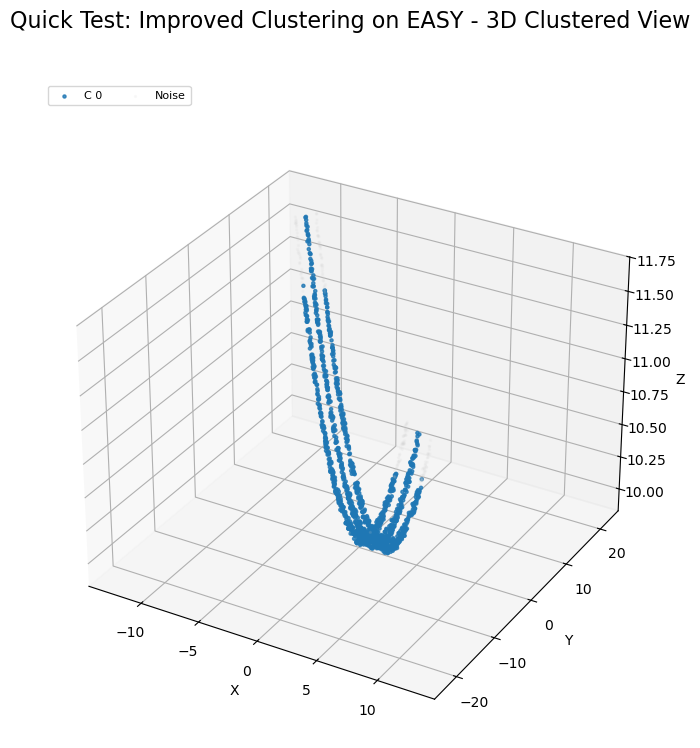


===== Tuning Parameters for MEDIUM Dataset =====

--- SOR preprocessing is DISABLED for MEDIUM. Using original data. ---

--- Current Parameters for MEDIUM (ImprovedWireClustering) ---
  Current settings: {'method': 'adaptive', 'adaptive_params': {'min_samples_ratio': 0.003, 'eps_multipliers': [1.0, 1.2, 1.5]}, 'hierarchical_params': {'distance_threshold': 1.0, 'linkage': 'single', 'min_cluster_size_merge': 15}, 'outlier_percentile': 90, 'min_final_cluster_size': 20, 'sor_enabled': False, 'sor_nb_neighbors': 20, 'sor_std_ratio': 2.0}
  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**
  **Then, re-run THIS CELL to apply and test your changes.**

--- Quick Test Run for MEDIUM with current `clustering_parameters` settings ---
  Test run for MEDIUM: Clusters=1, Noise=281


/var/folders/31/ftjtr3393td_3sj_dk6n1snr0000gn/T/ipykernel_22339/1490393179.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise))


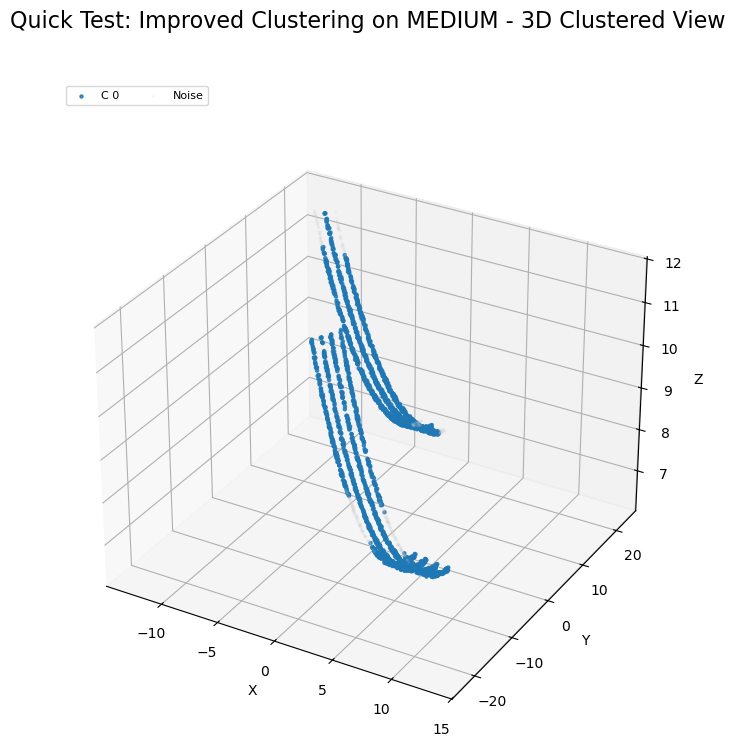


===== Tuning Parameters for HARD Dataset =====

--- Applying Statistical Outlier Removal (SOR) for HARD ---
  Applying SOR (scikit-learn): nb_neighbors=25, std_ratio=1.5...
  SOR finished in 0.00 seconds.
  Original points: 601, Inlier points: 557 (Removed: 44)

--- Current Parameters for HARD (ImprovedWireClustering) ---
  Current settings: {'method': 'hierarchical', 'adaptive_params': {'min_samples_ratio': 0.005, 'eps_multipliers': [0.8, 1.0, 1.2]}, 'hierarchical_params': {'distance_threshold': 1.2, 'linkage': 'single', 'min_cluster_size_merge': 20}, 'outlier_percentile': 85, 'min_final_cluster_size': 25, 'sor_enabled': True, 'sor_nb_neighbors': 25, 'sor_std_ratio': 1.5}
  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**
  **Then, re-run THIS CELL to apply and test your changes.**

--- Quick Test Run for HARD with current `clustering_parameters` settings ---


NameError: name 'KDTree' is not defined

In [6]:
# Cell 6: Interactive Parameter Tuning and Quick Test

print("--- Interactive Parameter Tuning for ImprovedWireClustering ---")
print("This section guides you in finding optimal parameters for each dataset using the new class.")
print("Observe the plots and metrics, then manually update the `clustering_parameters` dictionary below.")
print("Re-run this cell after each adjustment for a dataset to see its effect.")

# Dictionary to store the best parameters for each dataset
# You will tune these for the `process_lidar_data_with_improved_clustering` function.
clustering_parameters = {
    "easy": {
        "method": "adaptive", # Try 'adaptive' or 'hierarchical' or 'hybrid'
        "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "hierarchical_params": {"distance_threshold": 0.8, "linkage": "single", "min_cluster_size_merge": 10},
        "outlier_percentile": 90, # Percentile for final outlier removal
        "min_final_cluster_size": 15, # Final filter for very small clusters
        "sor_enabled": False, "sor_nb_neighbors": 20, "sor_std_ratio": 2.0
    },
    "medium": {
        "method": "adaptive",
        "adaptive_params": {"min_samples_ratio": 0.003, "eps_multipliers": [1.0, 1.2, 1.5]},
        "hierarchical_params": {"distance_threshold": 1.0, "linkage": "single", "min_cluster_size_merge": 15},
        "outlier_percentile": 90,
        "min_final_cluster_size": 20,
        "sor_enabled": False, "sor_nb_neighbors": 20, "sor_std_ratio": 2.0
    },
    "hard": {
        "method": "hierarchical", # Hierarchical might be better for hard
        "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "hierarchical_params": {"distance_threshold": 1.2, "linkage": "single", "min_cluster_size_merge": 20}, # Adjust threshold for noise
        "outlier_percentile": 85, # More aggressive outlier removal
        "min_final_cluster_size": 25,
        "sor_enabled": True, "sor_nb_neighbors": 25, "sor_std_ratio": 1.5
    },
    "extrahard": {
        "method": "hierarchical", # Hierarchical for high complexity
        "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "hierarchical_params": {"distance_threshold": 1.5, "linkage": "single", "min_cluster_size_merge": 30},
        "outlier_percentile": 80, # Very aggressive outlier removal
        "min_final_cluster_size": 40,
        "sor_enabled": True, "sor_nb_neighbors": 30, "sor_std_ratio": 1.0
    },
}

# Loop through each dataset to guide parameter selection and test
for name, df_original in lidar_dataframes.items():
    if df_original.empty:
        print(f"\nSkipping parameter tuning for empty dataset: {name.upper()}")
        continue

    print(f"\n===== Tuning Parameters for {name.upper()} Dataset =====")
    current_params = clustering_parameters.get(name, {})

    # --- Preprocessing Step: Statistical Outlier Removal (SOR) ---
    apply_sor_preprocessing = current_params.get("sor_enabled", False)
    if apply_sor_preprocessing:
        print(f"\n--- Applying Statistical Outlier Removal (SOR) for {name.upper()} ---")
        sor_nb = current_params.get("sor_nb_neighbors", 20)
        sor_std = current_params.get("sor_std_ratio", 2.0)
        df_for_improved_clustering = perform_sor_outlier_removal(df_original.copy(), nb_neighbors=sor_nb, std_ratio=sor_std)
    else:
        print(f"\n--- SOR preprocessing is DISABLED for {name.upper()}. Using original data. ---")
        df_for_improved_clustering = df_original.copy()

    if df_for_improved_clustering.empty:
        print(f"  Dataset {name.upper()} is empty after preprocessing. Skipping clustering guidance and test.")
        continue

    # --- Manual Input Block (IMPORTANT: YOU WILL EDIT THIS SECTION) ---
    print(f"\n--- Current Parameters for {name.upper()} (ImprovedWireClustering) ---")
    print(f"  Current settings: {current_params}")
    print(f"  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**")
    print(f"  **Then, re-run THIS CELL to apply and test your changes.**")

    # Example: When tuning for 'easy', you'd uncomment and set values like this:
    # if name == "easy":
    #     clustering_parameters[name] = {
    #         "method": "adaptive",
    #         "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.9, 1.1, 1.3]},
    #         "outlier_percentile": 92,
    #         "min_final_cluster_size": 20,
    #         "sor_enabled": False
    #     }
    #     print(f"  >>> UPDATED PARAMETERS for EASY: {clustering_parameters[name]} <<<")


    # --- Quick Test Run with Currently Defined Parameters ---
    print(f"\n--- Quick Test Run for {name.upper()} with current `clustering_parameters` settings ---")
    
    test_clustered_df = process_lidar_data_with_improved_clustering(
        df_for_improved_clustering.copy(),
        method=current_params.get("method"),
        adaptive_params=current_params.get("adaptive_params", {}),
        hierarchical_params=current_params.get("hierarchical_params", {}),
        outlier_percentile=current_params.get("outlier_percentile", 90),
        min_final_cluster_size=current_params.get("min_final_cluster_size", 10)
    )

    if not test_clustered_df.empty and 'cluster_id' in test_clustered_df.columns:
        test_num_clusters = test_clustered_df['cluster_id'].nunique() - (1 if -1 in test_clustered_df['cluster_id'].unique() else 0)
        test_num_noise = (test_clustered_df['cluster_id'] == -1).sum() if -1 in test_clustered_df['cluster_id'].unique() else 0
        print(f"  Test run for {name.upper()}: Clusters={test_num_clusters}, Noise={test_num_noise:,}")

        # --- 3D PLOTTING FOR QUICK TEST ---
        fig_3d = plt.figure(figsize=(10, 8))
        ax_3d = fig_3d.add_subplot(111, projection='3d')
        fig_3d.suptitle(f'Quick Test: Improved Clustering on {name.upper()} - 3D Clustered View', fontsize=16)

        unique_cluster_ids = sorted(test_clustered_df['cluster_id'].unique())
        cluster_ids_without_noise = [c_id for c_id in unique_cluster_ids if c_id != -1]
        colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise))

        for i, cluster_id in enumerate(cluster_ids_without_noise):
            cluster_data = test_clustered_df[test_clustered_df['cluster_id'] == cluster_id]
            color = colors_3d(i)
            ax_3d.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'],
                          s=5, color=color, label=f'C {cluster_id}', alpha=0.8)

        noise_data = test_clustered_df[test_clustered_df['cluster_id'] == -1]
        if not noise_data.empty:
            ax_3d.scatter(noise_data['x'], noise_data['y'], noise_data['z'],
                          s=2, color='lightgray', alpha=0.1, label='Noise')

        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.set_aspect('auto')
        if len(cluster_ids_without_noise) <= 10:
            ax_3d.legend(loc='lower left', bbox_to_anchor=(0.0, 1.02), ncol=4, fontsize=8)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()
    else:
        print(f"  Clustering for {name.upper()} resulted in empty or invalid DataFrame. No visualization possible.")

print("\n--- Parameter Tuning Complete. Review your `clustering_parameters` dictionary! ---")

--- Interactive Parameter Tuning for ImprovedWireClustering ---
This section guides you in finding optimal parameters for each dataset using the new class.
Observe the plots and metrics, then manually update the `clustering_parameters` dictionary below.
Re-run this cell after each adjustment for a dataset to see its effect.

===== Tuning Parameters for EASY Dataset =====

--- SOR preprocessing is DISABLED for EASY. Using original data. ---

--- Current Parameters for EASY (ImprovedWireClustering) ---
  Current settings: {'method': 'adaptive', 'adaptive_params': {'min_samples_ratio': 0.005, 'eps_multipliers': [0.8, 1.0, 1.2]}, 'hierarchical_params': {'distance_threshold': 0.8, 'linkage': 'single', 'min_cluster_size_merge': 10}, 'outlier_percentile': 90, 'min_final_cluster_size': 15, 'sor_enabled': False, 'sor_nb_neighbors': 20, 'sor_std_ratio': 2.0}
  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**
  **Then, re-run 

/var/folders/31/ftjtr3393td_3sj_dk6n1snr0000gn/T/ipykernel_22339/1490393179.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise))


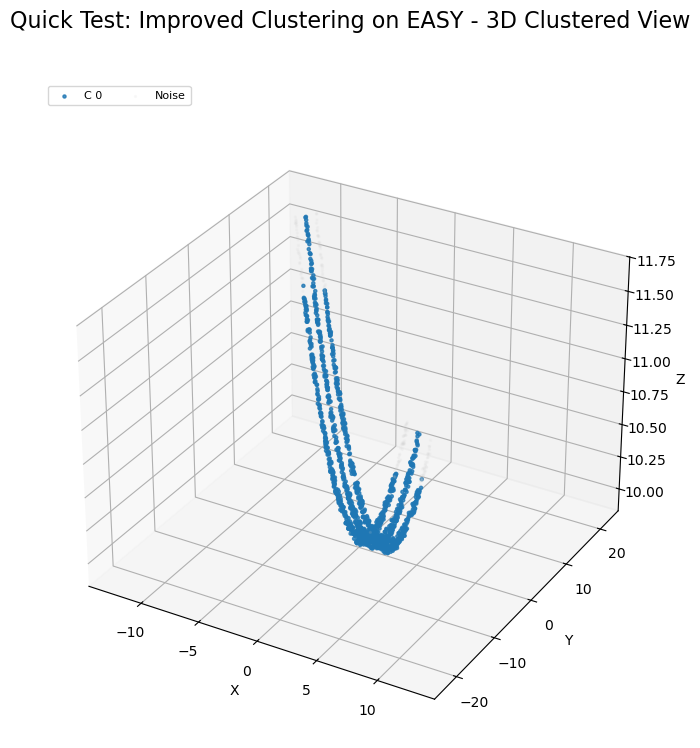


===== Tuning Parameters for MEDIUM Dataset =====

--- SOR preprocessing is DISABLED for MEDIUM. Using original data. ---

--- Current Parameters for MEDIUM (ImprovedWireClustering) ---
  Current settings: {'method': 'adaptive', 'adaptive_params': {'min_samples_ratio': 0.003, 'eps_multipliers': [1.0, 1.2, 1.5]}, 'hierarchical_params': {'distance_threshold': 1.0, 'linkage': 'single', 'min_cluster_size_merge': 15}, 'outlier_percentile': 90, 'min_final_cluster_size': 20, 'sor_enabled': False, 'sor_nb_neighbors': 20, 'sor_std_ratio': 2.0}
  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**
  **Then, re-run THIS CELL to apply and test your changes.**

--- Quick Test Run for MEDIUM with current `clustering_parameters` settings ---
  Test run for MEDIUM: Clusters=1, Noise=281


/var/folders/31/ftjtr3393td_3sj_dk6n1snr0000gn/T/ipykernel_22339/1490393179.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise))


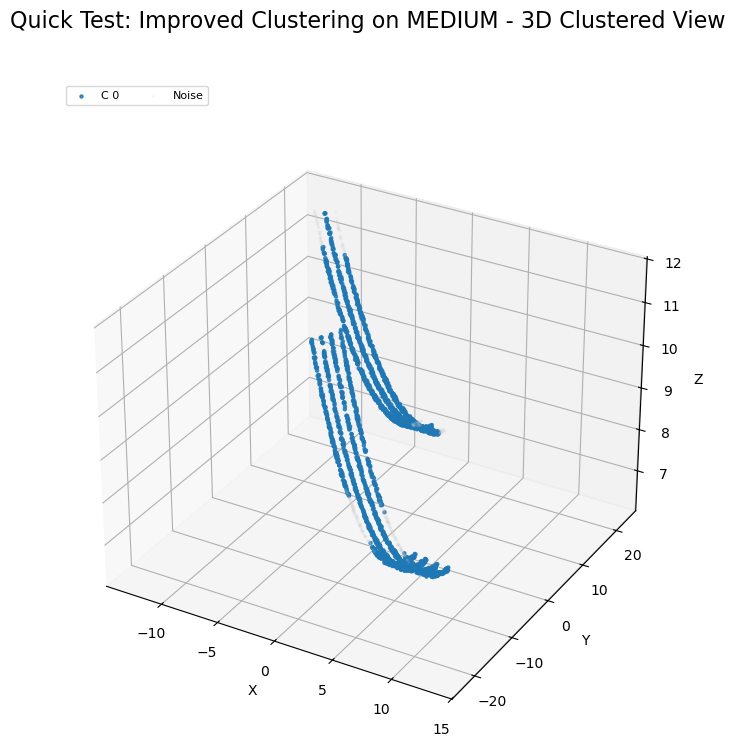


===== Tuning Parameters for HARD Dataset =====

--- Applying Statistical Outlier Removal (SOR) for HARD ---
  Applying SOR (scikit-learn): nb_neighbors=25, std_ratio=1.5...
  SOR finished in 0.00 seconds.
  Original points: 601, Inlier points: 557 (Removed: 44)

--- Current Parameters for HARD (ImprovedWireClustering) ---
  Current settings: {'method': 'hierarchical', 'adaptive_params': {'min_samples_ratio': 0.005, 'eps_multipliers': [0.8, 1.0, 1.2]}, 'hierarchical_params': {'distance_threshold': 1.2, 'linkage': 'single', 'min_cluster_size_merge': 20}, 'outlier_percentile': 85, 'min_final_cluster_size': 25, 'sor_enabled': True, 'sor_nb_neighbors': 25, 'sor_std_ratio': 1.5}
  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**
  **Then, re-run THIS CELL to apply and test your changes.**

--- Quick Test Run for HARD with current `clustering_parameters` settings ---


NameError: name 'KDTree' is not defined

In [7]:
# Cell 6: Interactive Parameter Tuning and Quick Test

print("--- Interactive Parameter Tuning for ImprovedWireClustering ---")
print("This section guides you in finding optimal parameters for each dataset using the new class.")
print("Observe the plots and metrics, then manually update the `clustering_parameters` dictionary below.")
print("Re-run this cell after each adjustment for a dataset to see its effect.")

# Dictionary to store the best parameters for each dataset
# You will tune these for the `process_lidar_data_with_improved_clustering` function.
clustering_parameters = {
    "easy": {
        "method": "adaptive", # Try 'adaptive' or 'hierarchical' or 'hybrid'
        "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "hierarchical_params": {"distance_threshold": 0.8, "linkage": "single", "min_cluster_size_merge": 10},
        "outlier_percentile": 90, # Percentile for final outlier removal
        "min_final_cluster_size": 15, # Final filter for very small clusters
        "sor_enabled": False, "sor_nb_neighbors": 20, "sor_std_ratio": 2.0
    },
    "medium": {
        "method": "adaptive",
        "adaptive_params": {"min_samples_ratio": 0.003, "eps_multipliers": [1.0, 1.2, 1.5]},
        "hierarchical_params": {"distance_threshold": 1.0, "linkage": "single", "min_cluster_size_merge": 15},
        "outlier_percentile": 90,
        "min_final_cluster_size": 20,
        "sor_enabled": False, "sor_nb_neighbors": 20, "sor_std_ratio": 2.0
    },
    "hard": {
        "method": "hierarchical", # Hierarchical might be better for hard
        "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "hierarchical_params": {"distance_threshold": 1.2, "linkage": "single", "min_cluster_size_merge": 20}, # Adjust threshold for noise
        "outlier_percentile": 85, # More aggressive outlier removal
        "min_final_cluster_size": 25,
        "sor_enabled": True, "sor_nb_neighbors": 25, "sor_std_ratio": 1.5
    },
    "extrahard": {
        "method": "hierarchical", # Hierarchical for high complexity
        "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "hierarchical_params": {"distance_threshold": 1.5, "linkage": "single", "min_cluster_size_merge": 30},
        "outlier_percentile": 80, # Very aggressive outlier removal
        "min_final_cluster_size": 40,
        "sor_enabled": True, "sor_nb_neighbors": 30, "sor_std_ratio": 1.0
    },
}

# Loop through each dataset to guide parameter selection and test
for name, df_original in lidar_dataframes.items():
    if df_original.empty:
        print(f"\nSkipping parameter tuning for empty dataset: {name.upper()}")
        continue

    print(f"\n===== Tuning Parameters for {name.upper()} Dataset =====")
    current_params = clustering_parameters.get(name, {})

    # --- Preprocessing Step: Statistical Outlier Removal (SOR) ---
    apply_sor_preprocessing = current_params.get("sor_enabled", False)
    if apply_sor_preprocessing:
        print(f"\n--- Applying Statistical Outlier Removal (SOR) for {name.upper()} ---")
        sor_nb = current_params.get("sor_nb_neighbors", 20)
        sor_std = current_params.get("sor_std_ratio", 2.0)
        df_for_improved_clustering = perform_sor_outlier_removal(df_original.copy(), nb_neighbors=sor_nb, std_ratio=sor_std)
    else:
        print(f"\n--- SOR preprocessing is DISABLED for {name.upper()}. Using original data. ---")
        df_for_improved_clustering = df_original.copy()

    if df_for_improved_clustering.empty:
        print(f"  Dataset {name.upper()} is empty after preprocessing. Skipping clustering guidance and test.")
        continue

    # --- Manual Input Block (IMPORTANT: YOU WILL EDIT THIS SECTION) ---
    print(f"\n--- Current Parameters for {name.upper()} (ImprovedWireClustering) ---")
    print(f"  Current settings: {current_params}")
    print(f"  **After reviewing the plots/guidance, manually edit the `clustering_parameters` dictionary in THIS CELL'S CODE BLOCK.**")
    print(f"  **Then, re-run THIS CELL to apply and test your changes.**")

    # Example: When tuning for 'easy', you'd uncomment and set values like this:
    # if name == "easy":
    #     clustering_parameters[name] = {
    #         "method": "adaptive",
    #         "adaptive_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.9, 1.1, 1.3]},
    #         "outlier_percentile": 92,
    #         "min_final_cluster_size": 20,
    #         "sor_enabled": False
    #     }
    #     print(f"  >>> UPDATED PARAMETERS for EASY: {clustering_parameters[name]} <<<")


    # --- Quick Test Run with Currently Defined Parameters ---
    print(f"\n--- Quick Test Run for {name.upper()} with current `clustering_parameters` settings ---")
    
    test_clustered_df = process_lidar_data_with_improved_clustering(
        df_for_improved_clustering.copy(),
        method=current_params.get("method"),
        adaptive_params=current_params.get("adaptive_params", {}),
        hierarchical_params=current_params.get("hierarchical_params", {}),
        outlier_percentile=current_params.get("outlier_percentile", 90),
        min_final_cluster_size=current_params.get("min_final_cluster_size", 10)
    )

    if not test_clustered_df.empty and 'cluster_id' in test_clustered_df.columns:
        test_num_clusters = test_clustered_df['cluster_id'].nunique() - (1 if -1 in test_clustered_df['cluster_id'].unique() else 0)
        test_num_noise = (test_clustered_df['cluster_id'] == -1).sum() if -1 in test_clustered_df['cluster_id'].unique() else 0
        print(f"  Test run for {name.upper()}: Clusters={test_num_clusters}, Noise={test_num_noise:,}")

        # --- 3D PLOTTING FOR QUICK TEST ---
        fig_3d = plt.figure(figsize=(10, 8))
        ax_3d = fig_3d.add_subplot(111, projection='3d')
        fig_3d.suptitle(f'Quick Test: Improved Clustering on {name.upper()} - 3D Clustered View', fontsize=16)

        unique_cluster_ids = sorted(test_clustered_df['cluster_id'].unique())
        cluster_ids_without_noise = [c_id for c_id in unique_cluster_ids if c_id != -1]
        colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise))

        for i, cluster_id in enumerate(cluster_ids_without_noise):
            cluster_data = test_clustered_df[test_clustered_df['cluster_id'] == cluster_id]
            color = colors_3d(i)
            ax_3d.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'],
                          s=5, color=color, label=f'C {cluster_id}', alpha=0.8)

        noise_data = test_clustered_df[test_clustered_df['cluster_id'] == -1]
        if not noise_data.empty:
            ax_3d.scatter(noise_data['x'], noise_data['y'], noise_data['z'],
                          s=2, color='lightgray', alpha=0.1, label='Noise')

        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.set_aspect('auto')
        if len(cluster_ids_without_noise) <= 10:
            ax_3d.legend(loc='lower left', bbox_to_anchor=(0.0, 1.02), ncol=4, fontsize=8)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()
    else:
        print(f"  Clustering for {name.upper()} resulted in empty or invalid DataFrame. No visualization possible.")

print("\n--- Parameter Tuning Complete. Review your `clustering_parameters` dictionary! ---")

In [ ]:
# NEW Cell (e.g., Cell 8): Define Post-Clustering Merging Function

from scipy.spatial import KDTree # For efficient nearest neighbor search
from sklearn.decomposition import PCA # For finding primary axis of clusters

def merge_proximal_aligned_clusters(clustered_df: pd.DataFrame,
                                    max_merge_distance: float = 3.0,
                                    max_angle_deg: float = 15.0,
                                    min_segment_points_for_pca: int = 5) -> pd.DataFrame:
    """
    Identifies and merges adjacent clusters that are aligned and close,
    likely representing fragments of the same wire.

    Args:
        clustered_df (pd.DataFrame): DataFrame with 'x', 'y', 'z', and 'cluster_id' columns
                                     after initial clustering.
        max_merge_distance (float): Maximum allowed distance between closest points/centroids
                                    of two segments to consider them for merging.
        max_angle_deg (float): Maximum angle (in degrees) between the primary PCA axes
                                of two segments for them to be considered aligned for merging.
        min_segment_points_for_pca (int): Minimum points a cluster must have to compute PCA
                                          for primary axis estimation. Smaller clusters won't
                                          have their direction checked.

    Returns:
        pd.DataFrame: A new DataFrame with 'cluster_id's updated after merging.
    """
    if clustered_df.empty or 'cluster_id' not in clustered_df.columns:
        print("  DataFrame is empty or missing 'cluster_id' column. Skipping merge refinement.")
        return clustered_df.copy()

    df_merged = clustered_df.copy()

    # --- Step 1: Extract properties for each valid cluster ---
    unique_labels = df_merged['cluster_id'].unique()
    valid_labels = [label for label in unique_labels if label != -1] # Exclude noise

    if not valid_labels:
        print("  No non-noise clusters found. Skipping merging.")
        return df_merged

    cluster_properties = {} # Stores centroid, primary_axis, size, etc.
    for label in valid_labels:
        cluster_points = df_merged[df_merged['cluster_id'] == label][['x', 'y', 'z']].values
        
        if len(cluster_points) >= min_segment_points_for_pca:
            centroid = np.mean(cluster_points, axis=0)
            
            pca = PCA(n_components=1) # Get the primary direction
            pca.fit(cluster_points)
            primary_axis = pca.components_[0]
            # Ensure consistent direction for angle calculation (e.g., always pointing positive in X)
            if primary_axis[0] < 0:
                primary_axis *= -1
            
            # Simple endpoint estimation (points furthest along primary axis)
            projected_coords = np.dot(cluster_points - centroid, primary_axis)
            p_min_idx = np.argmin(projected_coords)
            p_max_idx = np.argmax(projected_coords)
            endpoint1 = cluster_points[p_min_idx]
            endpoint2 = cluster_points[p_max_idx]

            cluster_properties[label] = {
                'centroid': centroid,
                'primary_axis': primary_axis,
                'size': len(cluster_points),
                'endpoints': (endpoint1, endpoint2)
            }
        else:
            # For very small clusters, we can't reliably get a primary axis.
            # Treat them as candidates for merging solely based on proximity (or mark as noise later).
            # For now, if too small for PCA, they are skipped for directional merging.
            # They will retain their original ID or be marked as noise later by min_final_cluster_size.
            pass

    # Filter out clusters too small for PCA from the processing list
    process_labels = [label for label in valid_labels if label in cluster_properties]
    if not process_labels:
        print("  No clusters large enough for PCA processing. Skipping directional merging.")
        return df_merged

    # --- Step 2: Find potential merges using KDTree on centroids ---
    centroids = np.array([cluster_properties[label]['centroid'] for label in process_labels])
    label_to_centroid_idx = {label: i for i, label in enumerate(process_labels)}
    
    # Handle case where only one valid cluster exists after filtering for PCA
    if len(centroids) < 2:
        print("  Less than 2 clusters large enough for directional merging. Skipping.")
        return df_merged
        
    kdtree_centroids = KDTree(centroids)

    # Store mergers to be applied. A list of (source_label, target_label)
    merges_to_apply = []
    
    # To prevent re-merging or processing already merged clusters
    already_merged = set() 

    for i, label1 in enumerate(process_labels):
        if label1 in already_merged:
            continue

        prop1 = cluster_properties[label1]
        
        # Find neighbors using KDTree query
        neighbor_indices = kdtree_centroids.query_ball_point(prop1['centroid'], r=max_merge_distance)
        
        for neighbor_idx in neighbor_indices:
            label2 = process_labels[neighbor_idx]
            if label1 == label2 or label2 in already_merged:
                continue
            
            prop2 = cluster_properties[label2]

            # Check alignment (angle between primary axes)
            dot_product = np.dot(prop1['primary_axis'], prop2['primary_axis'])
            angle_rad = np.arccos(np.clip(dot_product, -1.0, 1.0))
            angle_deg = np.degrees(angle_rad)
            
            # Consider both parallel and anti-parallel alignment
            if angle_deg > 90:
                angle_deg = 180 - angle_deg

            # Check if endpoints are close enough AND alignment is good
            # Calculate min distance between any of the 4 endpoints combinations
            dist_end1_end1 = np.linalg.norm(prop1['endpoints'][0] - prop2['endpoints'][0])
            dist_end1_end2 = np.linalg.norm(prop1['endpoints'][0] - prop2['endpoints'][1])
            dist_end2_end1 = np.linalg.norm(prop1['endpoints'][1] - prop2['endpoints'][0])
            dist_end2_end2 = np.linalg.norm(prop1['endpoints'][1] - prop2['endpoints'][1])
            min_endpoint_distance = min(dist_end1_end1, dist_end1_end2, dist_end2_end1, dist_end2_end2)

            if angle_deg < max_angle_deg and min_endpoint_distance < max_merge_distance:
                # Merge label2 into label1
                merges_to_apply.append((label2, label1))
                already_merged.add(label2) # Mark label2 as processed/merged

    # --- Step 3: Apply Merges ---
    if merges_to_apply:
        print(f"  Applying {len(merges_to_apply)} merge operations...")
        # Create a mapping from old IDs to new IDs
        id_map = {label: label for label in df_merged['cluster_id'].unique()}
        for source_label, target_label in merges_to_apply:
            id_map[source_label] = target_label
        
        df_merged['cluster_id'] = df_merged['cluster_id'].map(id_map)
        
        # Re-map cluster IDs to be contiguous after merging
        final_unique_labels = df_merged['cluster_id'].unique()
        final_valid_labels = sorted([label for label in final_unique_labels if label != -1])
        new_id_map = {old_label: new_id for new_id, old_label in enumerate(final_valid_labels)}
        new_id_map[-1] = -1 # Ensure noise remains -1
        df_merged['cluster_id'] = df_merged['cluster_id'].map(new_id_map)
        
        print("  Merges applied. Re-mapping cluster IDs for contiguity.")
    else:
        print("  No significant merges found based on current parameters.")

    final_num_clusters = df_merged['cluster_id'].nunique() - (1 if -1 in df_merged['cluster_id'].unique() else 0)
    final_num_noise = (df_merged['cluster_id'] == -1).sum() if -1 in df_merged['cluster_id'].unique() else 0
    print(f"  Post-clustering merge refinement complete. Final clusters: {final_num_clusters}, Noise: {final_num_noise:,}")

    return df_merged

print("`merge_proximal_aligned_clusters` function defined.")

In [8]:
# Cell 7: Apply Final Clustering and Visualize (Main Pipeline Step)

print("\n--- Applying Final Clustering to Each Dataset Based on Tuned Parameters ---")
processed_lidar_dataframes = {} # To store DataFrames with cluster IDs for subsequent steps

# --- Parameters for Post-Clustering Merging ---
# These parameters are for `merge_proximal_aligned_clusters`
# They define how close and how aligned segments need to be to be merged into one wire.
merge_params = {
    "easy": {"max_merge_distance": 0.5, "max_angle_deg": 5.0, "min_segment_points_for_pca": 5}, # <--- TUNE THESE
    "medium": {"max_merge_distance": 1.0, "max_angle_deg": 10.0, "min_segment_points_for_pca": 8},
    "hard": {"max_merge_distance": 2.0, "max_angle_deg": 15.0, "min_segment_points_for_pca": 10},
    "extrahard": {"max_merge_distance": 3.0, "max_angle_deg": 20.0, "min_segment_points_for_pca": 15},
}


for name, df_original in lidar_dataframes.items():
    if df_original.empty:
        print(f"\nSkipping final clustering for empty dataset: {name.upper()}")
        continue

    print(f"\n===== Running Final Clustering for {name.upper()} Dataset =====")
    params = clustering_parameters.get(name) # Get your FINAL tuned parameters

    if not params:
        print(f"  No final clustering parameters defined for {name.upper()}. Skipping final clustering.")
        processed_lidar_dataframes[name] = df_original.copy()
        continue

    # --- Preprocessing Step: Statistical Outlier Removal (SOR) ---
    apply_sor_final = params.get("sor_enabled", False)
    if apply_sor_final:
        print(f"  Applying Statistical Outlier Removal (SOR) for {name.upper()}...")
        sor_nb_final = params.get("sor_nb_neighbors", 20)
        sor_std_final = params.get("sor_std_ratio", 2.0)
        df_after_sor = perform_sor_outlier_removal(df_original.copy(), nb_neighbors=sor_nb_final, std_ratio=sor_std_final)
    else:
        print(f"  SOR preprocessing is DISABLED for {name.upper()} in final run. Using original data.")
        df_after_sor = df_original.copy()

    if df_after_sor.empty:
        print(f"  Dataset {name.upper()} is empty after SOR. Skipping final clustering and visualization.")
        processed_lidar_dataframes[name] = df_original.copy()
        continue

    # --- Optional Preprocessing Step: RANSAC Plane Removal ---
    apply_ransac_plane_removal_pre_clustering = False
    
    df_for_final_improved_clustering = df_after_sor.copy()

    if apply_ransac_plane_removal_pre_clustering and params.get("method") not in ["RANSAC_Plane"]:
        print(f"\n--- Applying RANSAC Plane REMOVAL (Pre-Clustering) for {name.upper()} ---")
        temp_df_with_planes_id = perform_ransac_plane_segmentation(
            df_for_final_improved_clustering.copy(),
            distance_threshold=0.1,
            min_points_in_plane=100,
            num_planes_to_find=1
        )
        df_after_plane_removal = temp_df_with_planes_id[temp_df_with_planes_id['cluster_id'] == -1].copy()
        
        if df_after_plane_removal.empty:
            print(f"    All points removed by RANSAC plane removal. No wires left for {name.upper()}.")
            processed_lidar_dataframes[name] = df_original.copy()
            continue
        
        print(f"    Removed {len(df_for_final_improved_clustering) - len(df_after_plane_removal):,} plane points. Remaining: {len(df_after_plane_removal):,}")
        df_for_final_improved_clustering = df_after_plane_removal
    else:
        print(f"  RANSAC Plane Removal (Pre-Clustering) is DISABLED for {name.upper()}.")

    # --- Perform Final Clustering using ImprovedWireClustering ---
    final_clustered_df = pd.DataFrame()
    try:
        if params.get("method") == "RANSAC_Plane":
            print(f"  Applying RANSAC Plane Segmentation with distance_threshold={params['distance_threshold']}...")
            initial_clustered_df = perform_ransac_plane_segmentation(
                df_for_final_improved_clustering.copy(),
                distance_threshold=params['distance_threshold'],
                min_points_in_plane=params['min_points_in_plane'],
                num_planes_to_find=params['num_planes_to_find'],
                random_state=params.get("random_state")
            )
        else: # For 'adaptive', 'hierarchical', 'hybrid' which are handled by the class
            print(f"  Applying ImprovedWireClustering with method='{params.get('method')}' for {name.upper()}...")
            initial_clustered_df = process_lidar_data_with_improved_clustering(
                df_for_final_improved_clustering.copy(),
                method=params.get("method"),
                adaptive_params=params.get("adaptive_params", {}),
                hierarchical_params=params.get("hierarchical_params", {}),
                outlier_percentile=params.get("outlier_percentile", 90),
                min_final_cluster_size=params.get("min_final_cluster_size", 10)
            )

        # --- NEW: Apply Post-Clustering Merging (Step 1 of improvements) ---
        print(f"\n--- Applying Post-Clustering Merging for {name.upper()} ---")
        current_merge_params = merge_params.get(name, {})
        if not current_merge_params:
            print(f"  No merge parameters defined for {name.upper()}. Skipping merging.")
            final_clustered_df = initial_clustered_df.copy() # Use initial clusters
        else:
            final_clustered_df = merge_proximal_aligned_clusters(
                initial_clustered_df.copy(), # Input is the result of initial clustering
                max_merge_distance=current_merge_params.get("max_merge_distance", 3.0),
                max_angle_deg=current_merge_params.get("max_angle_deg", 15.0),
                min_segment_points_for_pca=current_merge_params.get("min_segment_points_for_pca", 10)
            )

        processed_lidar_dataframes[name] = final_clustered_df # Store the final merged DF
        
        num_clusters_final_refined = final_clustered_df['cluster_id'].nunique() - (1 if -1 in final_clustered_df['cluster_id'].unique() else 0)
        num_noise_final_refined = (final_clustered_df['cluster_id'] == -1).sum() if -1 in final_clustered_df['cluster_id'].unique() else 0
        print(f"  Final (merged) clustering for {name.upper()} completed. Found {num_clusters_final_refined} wires and {num_noise_final_refined:,} noise points.")

        # --- Final Visualization of Clustered Results (3D Plot Only) ---
        print(f"\n--- Final Visualization of Merged Clustered Results for {name.upper()} ---")
        print("Each unique cluster (wire) will be shown in a different color. Noise points are faint grey.")

        fig_3d = plt.figure(figsize=(10, 8))
        ax_3d = fig_3d.add_subplot(111, projection='3d')
        fig_3d.suptitle(f'Final Merged Clustered Points - {name.upper()} - 3D View', fontsize=16)

        unique_cluster_ids_3d = sorted(final_clustered_df['cluster_id'].unique())
        cluster_ids_without_noise_3d = [c_id for c_id in unique_cluster_ids_3d if c_id != -1]
        colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise_3d))

        for i, cluster_id in enumerate(cluster_ids_without_noise_3d):
            cluster_data = final_clustered_df[final_clustered_df['cluster_id'] == cluster_id]
            color = colors_3d(i)
            ax_3d.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'],
                          s=5, color=color, label=f'C {cluster_id}', alpha=0.8)

        noise_data_3d = final_clustered_df[final_clustered_df['cluster_id'] == -1]
        if not noise_data_3d.empty:
            ax_3d.scatter(noise_data_3d['x'], noise_data_3d['y'], noise_data_3d['z'],
                          s=2, color='lightgray', alpha=0.1, label='Noise')

        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.set_aspect('auto')
        if len(cluster_ids_without_noise_3d) <= 10:
            ax_3d.legend(loc='lower left', bbox_to_anchor=(0.0, 1.02), ncol=4, fontsize=8)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"  An error occurred during final clustering or visualization for {name.upper()}: {e}")
        processed_lidar_dataframes[name] = df_original.copy()


print("\n--- Final Clustering pipeline for all datasets complete. Now ready for Plane Fitting! ---")


--- Applying Final Clustering to Each Dataset Based on Tuned Parameters ---

===== Running Final Clustering for EASY Dataset =====
  SOR preprocessing is DISABLED for EASY in final run. Using original data.
  RANSAC Plane Removal (Pre-Clustering) is DISABLED for EASY.
  Applying ImprovedWireClustering with method='adaptive' for EASY...

--- Applying Post-Clustering Merging for EASY ---
  An error occurred during final clustering or visualization for EASY: name 'merge_proximal_aligned_clusters' is not defined

===== Running Final Clustering for MEDIUM Dataset =====
  SOR preprocessing is DISABLED for MEDIUM in final run. Using original data.
  RANSAC Plane Removal (Pre-Clustering) is DISABLED for MEDIUM.
  Applying ImprovedWireClustering with method='adaptive' for MEDIUM...

--- Applying Post-Clustering Merging for MEDIUM ---
  An error occurred during final clustering or visualization for MEDIUM: name 'merge_proximal_aligned_clusters' is not defined

===== Running Final Clustering for

In [9]:
from scipy.spatial import KDTree
# NEW Cell (e.g., Cell 9): Advanced Clustering Experimentation

# Add this import at the very top of this cell

print("\n--- Advanced Clustering Experimentation ---")
print("Exploring algorithm enhancements and data quality improvements as suggested.")
print("This cell will contain functions and logic for:")
print("1. Adaptive parameters based on local density (for DBSCAN/HDBSCAN).")
print("2. Hierarchical multi-scale clustering (conceptual, often HDBSCAN's strength).")
print("3. Pre-filtering obvious outliers (already using SOR, can be enhanced).")
print("4. Point density normalization (conceptual/feature engineering).")
print("5. Feature engineering (adding local geometric features).")


# --- Part A: Enhanced Preprocessing / Feature Engineering Functions ---

def calculate_local_features(points_df: pd.DataFrame, radius: float = 0.5, min_neighbors_for_pca: int = 5) -> pd.DataFrame:
    """
    Calculates local geometric features for each point in the point cloud.
    Features include: local density, linearity, direction vector.
    """
    # CORRECTED LINE BELOW:
    if points_df.empty or not all(col in points_df.columns for col in ['x', 'y', 'z']): # <--- CORRECTED THIS LINE
        print("  Input DataFrame is empty or missing x,y,z columns for feature engineering.")
        return points_df.copy() # Return original if invalid
    
    points_np = points_df[['x', 'y', 'z']].values.astype(np.float64)
    features_df = points_df.copy() # Start with original DataFrame to add features

    # Build KDTree for efficient neighbor lookup
    kdtree = KDTree(points_np)
    
    local_linearities = np.zeros(len(points_np))
    local_height_variances = np.zeros(len(points_np))
    local_densities = np.zeros(len(points_np))
    local_directions = np.zeros((len(points_np), 3)) # For direction vector components

    print(f"  Calculating local features (radius={radius}, min_neighbors_for_pca={min_neighbors_for_pca})...")
    start_time = time.time()

    for i, point in enumerate(points_np):
        neighbors_indices = kdtree.query_ball_point(point, r=radius)
        neighbor_points = points_np[neighbors_indices]
        
        if len(neighbor_points) >= min_neighbors_for_pca:
            # PCA for linearity and direction
            pca = PCA(n_components=3)
            pca.fit(neighbor_points)
            
            # Linearity: Explained variance ratio of the first principal component
            linearity = pca.explained_variance_ratio_[0] if np.sum(pca.explained_variance_ratio_) > 0 else 0.0
            
            # Height variation (variance of Z in neighborhood)
            height_var = np.var(neighbor_points[:, 2])
            
            # Local Density: number of neighbors within sphere volume
            density = len(neighbors_indices) / (4/3 * np.pi * radius**3)
            
            # Primary direction vector
            direction = pca.components_[0]
            if direction[0] < 0: # Normalize direction consistently
                direction *= -1

            local_linearities[i] = linearity
            local_height_variances[i] = height_var
            local_densities[i] = density
            local_directions[i, :] = direction
        
    features_df['linearity'] = local_linearities
    features_df['height_var'] = local_height_variances
    features_df['density'] = local_densities
    features_df['dir_x'] = local_directions[:, 0]
    features_df['dir_y'] = local_directions[:, 1]
    features_df['dir_z'] = local_directions[:, 2]

    end_time = time.time()
    print(f"  Feature calculation finished in {end_time - start_time:.2f} seconds.")
    return features_df

def normalize_features(df_with_features: pd.DataFrame, features_to_normalize: list) -> pd.DataFrame:
    """
    Normalizes specified feature columns using StandardScaler.
    """
    df_normalized = df_with_features.copy()
    for feature in features_to_normalize:
        if feature in df_normalized.columns and len(df_normalized[feature].unique()) > 1: # Only normalize if not constant
            try:
                df_normalized[feature] = StandardScaler().fit_transform(df_normalized[[feature]])
            except Exception as e:
                print(f"  Warning: Could not normalize feature '{feature}': {e}. Skipping.")
    print("  Features normalized.")
    return df_normalized

# --- Part B: Advanced Clustering Algorithm Functions (Modified from ImprovedWireClustering for standalone use) ---

# Re-define adaptive_dbscan (if you want to use it directly in this cell, without the class instance)
# For this advanced section, we will call it from within the loop with generated features.

# --- Part C: Main Experimentation Loop ---

print("\n--- Running Advanced Clustering Experiments on Each Dataset ---")

# Define parameters for these advanced experiments
# You will select which algorithm combination to use for each dataset here.
advanced_clustering_experiments = {
    "easy": {
        "strategy": "feature_based_hierarchical", # Option: "feature_based_hierarchical", "adaptive_dbscan_enhanced"
        "feature_params": {"radius": 0.5, "min_neighbors_for_pca": 5},
        "hierarchical_params": {"distance_threshold": 0.8, "linkage": "single", "min_cluster_size_merge": 10},
        "adaptive_dbscan_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]}, # For future use/comparison
        "min_final_cluster_size": 15,
        "outlier_percentile": 90,
        "sor_enabled": False, "sor_nb_neighbors": 20, "sor_std_ratio": 2.0
    },
    "medium": {
        "strategy": "feature_based_hierarchical",
        "feature_params": {"radius": 0.8, "min_neighbors_for_pca": 8},
        "hierarchical_params": {"distance_threshold": 1.2, "linkage": "single", "min_cluster_size_merge": 15},
        "adaptive_dbscan_params": {"min_samples_ratio": 0.003, "eps_multipliers": [1.0, 1.2, 1.5]},
        "min_final_cluster_size": 20,
        "outlier_percentile": 88,
        "sor_enabled": False, "sor_nb_neighbors": 20, "sor_std_ratio": 2.0
    },
    "hard": {
        "strategy": "feature_based_hierarchical",
        "feature_params": {"radius": 1.0, "min_neighbors_for_pca": 10},
        "hierarchical_params": {"distance_threshold": 1.5, "linkage": "single", "min_cluster_size_merge": 20},
        "adaptive_dbscan_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "min_final_cluster_size": 25,
        "outlier_percentile": 85,
        "sor_enabled": True, "sor_nb_neighbors": 25, "sor_std_ratio": 1.5
    },
    "extrahard": {
        "strategy": "feature_based_hierarchical",
        "feature_params": {"radius": 1.2, "min_neighbors_for_pca": 15},
        "hierarchical_params": {"distance_threshold": 2.0, "linkage": "single", "min_cluster_size_merge": 30},
        "adaptive_dbscan_params": {"min_samples_ratio": 0.005, "eps_multipliers": [0.8, 1.0, 1.2]},
        "min_final_cluster_size": 35,
        "outlier_percentile": 80,
        "sor_enabled": True, "sor_nb_neighbors": 30, "sor_std_ratio": 1.0
    },
}

# This dictionary will store the final results of these advanced experiments
advanced_clustered_dataframes = {}

for name, df_original in lidar_dataframes.items(): # Use original data from Cell 5
    if df_original.empty:
        print(f"\nSkipping advanced clustering for empty dataset: {name.upper()}")
        continue

    print(f"\n===== Running Advanced Clustering for {name.upper()} Dataset =====")
    exp_params = advanced_clustering_experiments.get(name)

    if not exp_params:
        print(f"  No advanced experiment parameters defined for {name.upper()}. Skipping.")
        continue

    # --- Pre-filter obvious outliers (SOR) ---
    df_current = df_original.copy()
    if exp_params.get("sor_enabled", False):
        print(f"  Applying SOR (nb_neighbors={exp_params['sor_nb_neighbors']}, std_ratio={exp_params['sor_std_ratio']})...")
        df_current = perform_sor_outlier_removal(df_current, 
                                                 nb_neighbors=exp_params['sor_nb_neighbors'], 
                                                 std_ratio=exp_params['sor_std_ratio'])
    
    if df_current.empty:
        print(f"  Dataset {name.upper()} is empty after SOR. Skipping advanced clustering.")
        continue

    # --- Feature Engineering ---
    print(f"\n--- Extracting and Normalizing Features for {name.upper()} ---")
    df_with_features = calculate_local_features(df_current.copy(), 
                                                radius=exp_params['feature_params']['radius'], 
                                                min_neighbors_for_pca=exp_params['feature_params']['min_neighbors_for_pca'])
    
    # Define features to normalize (x,y,z can be useful too if coordinates vary widely, but often better to keep raw)
    features_to_normalize_list = ['linearity', 'height_var', 'density', 'dir_x', 'dir_y', 'dir_z']
    df_scaled_features = normalize_features(df_with_features.copy(), features_to_normalize_list)
    
    # Select features for clustering (can include x,y,z or just geometric features)
    features_for_clustering = df_scaled_features[['x', 'y', 'z'] + features_to_normalize_list].values # Using all features


    # --- Apply Chosen Advanced Clustering Strategy ---
    labels = np.full(len(features_for_clustering), -1) # Default to noise
    clusterer_instance = ImprovedWireClustering() # Create an instance of your class
    
    print(f"\n--- Applying strategy: '{exp_params['strategy']}' for {name.upper()} ---")
    try:
        if exp_params['strategy'] == "feature_based_hierarchical":
            # Hierarchical clustering on the feature space
            hier_params = exp_params['hierarchical_params']
            labels = clusterer_instance.hierarchical_clustering_with_constraints(
                features_for_clustering, # Clustering on engineered features
                distance_threshold=hier_params['distance_threshold'],
                linkage=hier_params['linkage'],
                min_cluster_size_merge=hier_params['min_cluster_size_merge']
            )
        elif exp_params['strategy'] == "adaptive_dbscan_enhanced":
            # Adaptive DBSCAN on feature space
            adapt_params = exp_params['adaptive_dbscan_params']
            labels = clusterer_instance.adaptive_dbscan(
                features_for_clustering, # Clustering on engineered features
                min_samples_ratio=adapt_params['min_samples_ratio'],
                eps_multipliers=adapt_params['eps_multipliers']
            )
        else:
            print(f"  Unknown advanced strategy '{exp_params['strategy']}'. Skipping clustering for {name.upper()}.")
            continue # Skip to next dataset
        
        # Apply outlier removal from ImprovedWireClustering class
        labels = clusterer_instance.remove_outliers(features_for_clustering, labels, 
                                                     percentile_threshold=exp_params.get("outlier_percentile", 90))

        final_df_advanced_clustered = df_original.copy() # Start with original for final result
        final_df_advanced_clustered['cluster_id'] = labels

        # Apply final size filter (min_final_cluster_size)
        if not final_df_advanced_clustered.empty and 'cluster_id' in final_df_advanced_clustered.columns:
            counts = final_df_advanced_clustered['cluster_id'].value_counts()
            small_clusters_ids = counts[counts < exp_params['min_final_cluster_size']].index
            final_df_advanced_clustered.loc[final_df_advanced_clustered['cluster_id'].isin(small_clusters_ids), 'cluster_id'] = -1
            
            # Re-map cluster IDs
            unique_valid_ids = sorted(final_df_advanced_clustered[final_df_advanced_clustered['cluster_id'] != -1]['cluster_id'].unique())
            valid_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_valid_ids)}
            final_df_advanced_clustered.loc[final_df_advanced_clustered['cluster_id'] != -1, 'cluster_id'] = final_df_advanced_clustered.loc[final_df_advanced_clustered['cluster_id'] != -1, 'cluster_id'].map(valid_id_map)
        
        advanced_clustered_dataframes[name] = final_df_advanced_clustered # Store final result

        num_clusters_found = final_df_advanced_clustered['cluster_id'].nunique() - (1 if -1 in final_df_advanced_clustered['cluster_id'].unique() else 0)
        num_noise_points = (final_df_advanced_clustered['cluster_id'] == -1).sum() if -1 in final_df_advanced_clustered['cluster_id'].unique() else 0
        print(f"  Advanced clustering for {name.upper()} completed. Found {num_clusters_found} wires and {num_noise_points:,} noise points.")

        # --- Final Visualization of Clustered Results (3D Plot Only) ---
        print(f"\n--- Visualization of Advanced Clustered Results for {name.upper()} ---")
        print("Each unique cluster (wire) will be shown in a different color. Noise points are faint grey.")

        fig_3d = plt.figure(figsize=(10, 8))
        ax_3d = fig_3d.add_subplot(111, projection='3d')
        fig_3d.suptitle(f'Advanced Clustered Points - {name.upper()} - 3D View', fontsize=16)

        unique_cluster_ids_3d = sorted(final_df_advanced_clustered['cluster_id'].unique())
        cluster_ids_without_noise_3d = [c_id for c_id in unique_cluster_ids_3d if c_id != -1]
        colors_3d = plt.cm.get_cmap('tab20', len(cluster_ids_without_noise_3d))

        for i, cluster_id in enumerate(cluster_ids_without_noise_3d):
            cluster_data = final_df_advanced_clustered[final_df_advanced_clustered['cluster_id'] == cluster_id]
            color = colors_3d(i)
            ax_3d.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'],
                          s=5, color=color, label=f'C {cluster_id}', alpha=0.8)

        noise_data_3d = final_df_advanced_clustered[final_df_advanced_clustered['cluster_id'] == -1]
        if not noise_data_3d.empty:
            ax_3d.scatter(noise_data_3d['x'], noise_data_3d['y'], noise_data_3d['z'],
                          s=2, color='lightgray', alpha=0.1, label='Noise')

        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.set_aspect('auto')
        if len(cluster_ids_without_noise_3d) <= 10:
            ax_3d.legend(loc='lower left', bbox_to_anchor=(0.0, 1.02), ncol=4, fontsize=8)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"  An error occurred during advanced clustering for {name.upper()}: {e}")
        # Store original data if processing fails
        advanced_clustered_dataframes[name] = df_original.copy()
        if 'cluster_id' not in advanced_clustered_dataframes[name].columns:
            advanced_clustered_dataframes[name]['cluster_id'] = -1


print("\n--- Advanced Clustering Experimentation Complete ---")


--- Advanced Clustering Experimentation ---
Exploring algorithm enhancements and data quality improvements as suggested.
This cell will contain functions and logic for:
1. Adaptive parameters based on local density (for DBSCAN/HDBSCAN).
2. Hierarchical multi-scale clustering (conceptual, often HDBSCAN's strength).
3. Pre-filtering obvious outliers (already using SOR, can be enhanced).
4. Point density normalization (conceptual/feature engineering).
5. Feature engineering (adding local geometric features).

--- Running Advanced Clustering Experiments on Each Dataset ---

===== Running Advanced Clustering for EASY Dataset =====

--- Extracting and Normalizing Features for EASY ---
  Calculating local features (radius=0.5, min_neighbors_for_pca=5)...
  Feature calculation finished in 0.18 seconds.
  Features normalized.

--- Applying strategy: 'feature_based_hierarchical' for EASY ---
  An error occurred during advanced clustering for EASY: too many values to unpack (expected 3)

===== R